In [1]:
import geopandas as gpd
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import numpy as np
import pandas as pd
import requests

# 1. The levee data

In [2]:
levee_gdf = gpd.read_file("/share/gpu1/lshi/fathom/data/levee/downloads/levees.gpkg", layer="System")

Visualise all the levees:

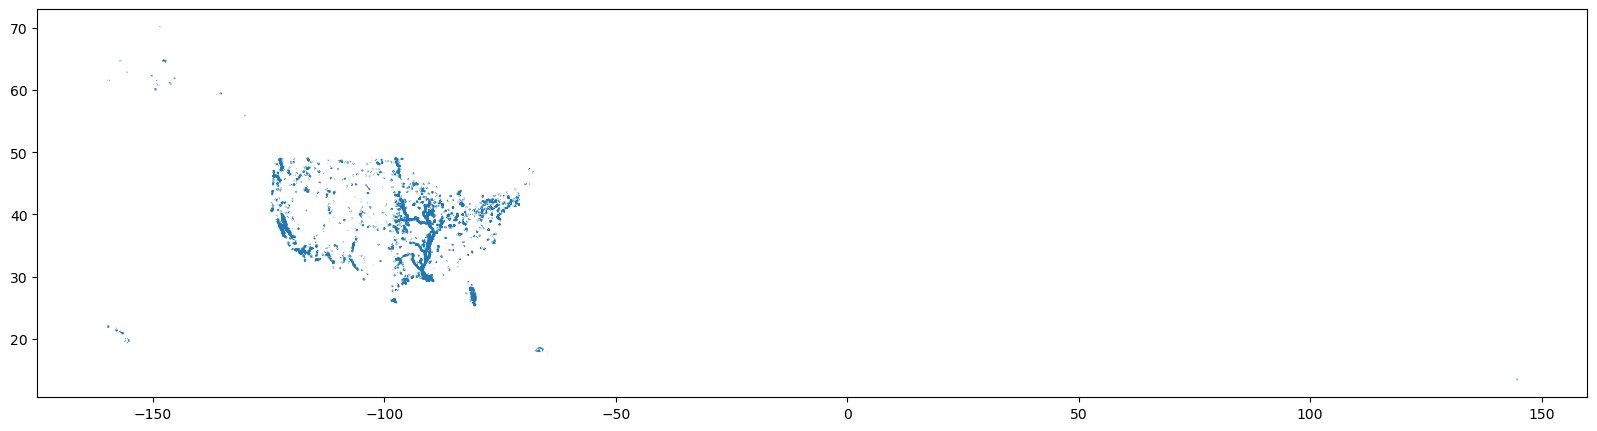

In [3]:
fig, ax = plt.subplots(figsize=(20, 20))
levee_gdf['geometry'].plot(ax=ax);

Zoom-in a bit:

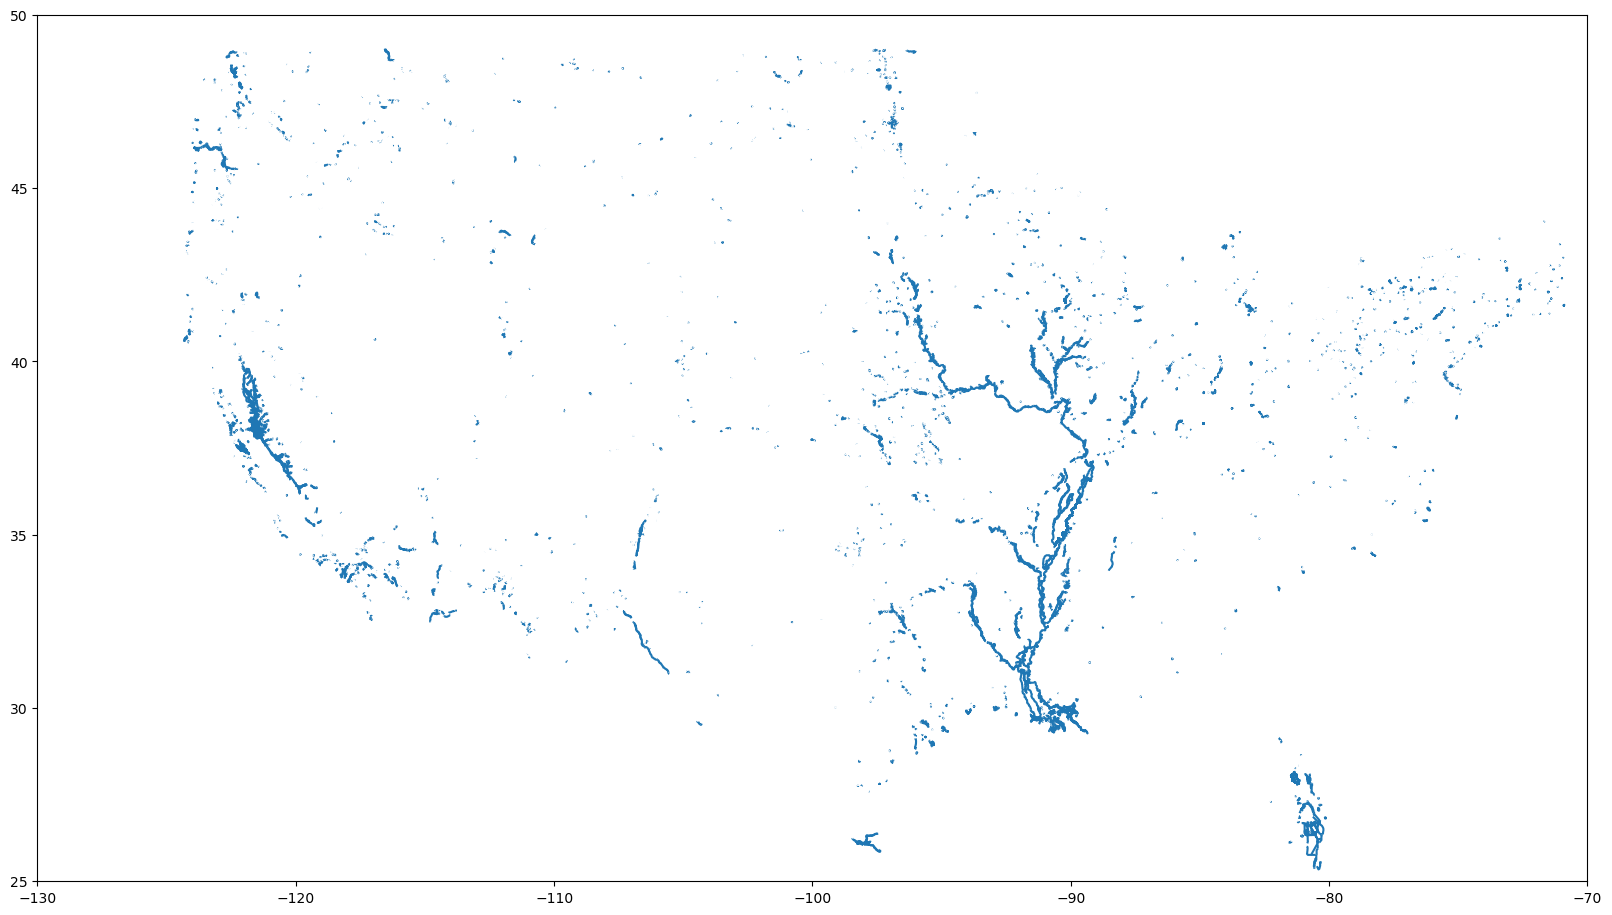

In [4]:
ax.set_xlim(-130, -70)
ax.set_ylim(25, 50)
fig

# 2. The bounding box of the levees

The first approach that came to mind for building the downloading request is to use the bounding boxes of each levee. We will see below why this isn't a good idea.

Let's visualise all the bounding boxes:

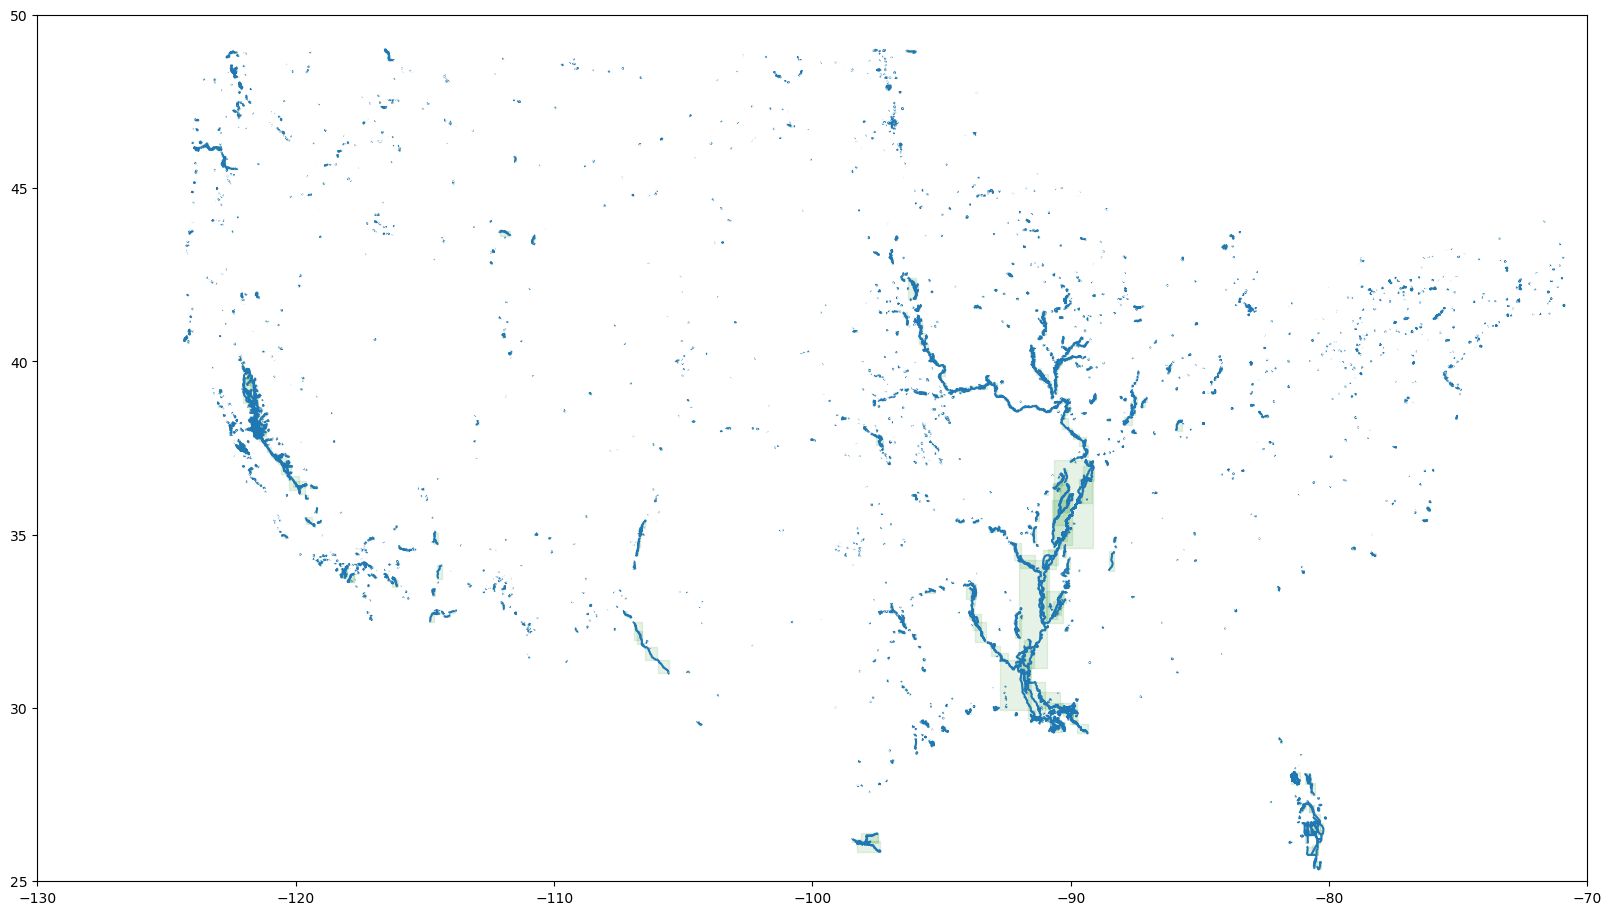

In [5]:
# Get the levee bounds
levee_bounds = levee_gdf[["name", "geometry"]].geometry.bounds

# plot levee bounds together with the levee data
fig, ax = plt.subplots(figsize=(20, 20))
levee_gdf['geometry'].plot(ax=ax)

patches = []
for index, bound in levee_bounds.iterrows():
    patches.append(Rectangle(
        xy=(bound['minx'], bound['miny']), 
        width=bound['maxx']-bound['minx'], 
        height=bound['maxy']-bound['miny'],
    ))
ax.add_collection(PatchCollection(patches, facecolor='g', edgecolor='g', alpha=0.1))
ax.set_xlim(-130, -70)
ax.set_ylim(25, 50)
plt.show()

We can see many overlaps the areas of the bounding boxes vary a lot. This will lead to nonuniform downloading requests. Some of the requests may be too large and the response will be truncated.

If we zoom-in a bit:

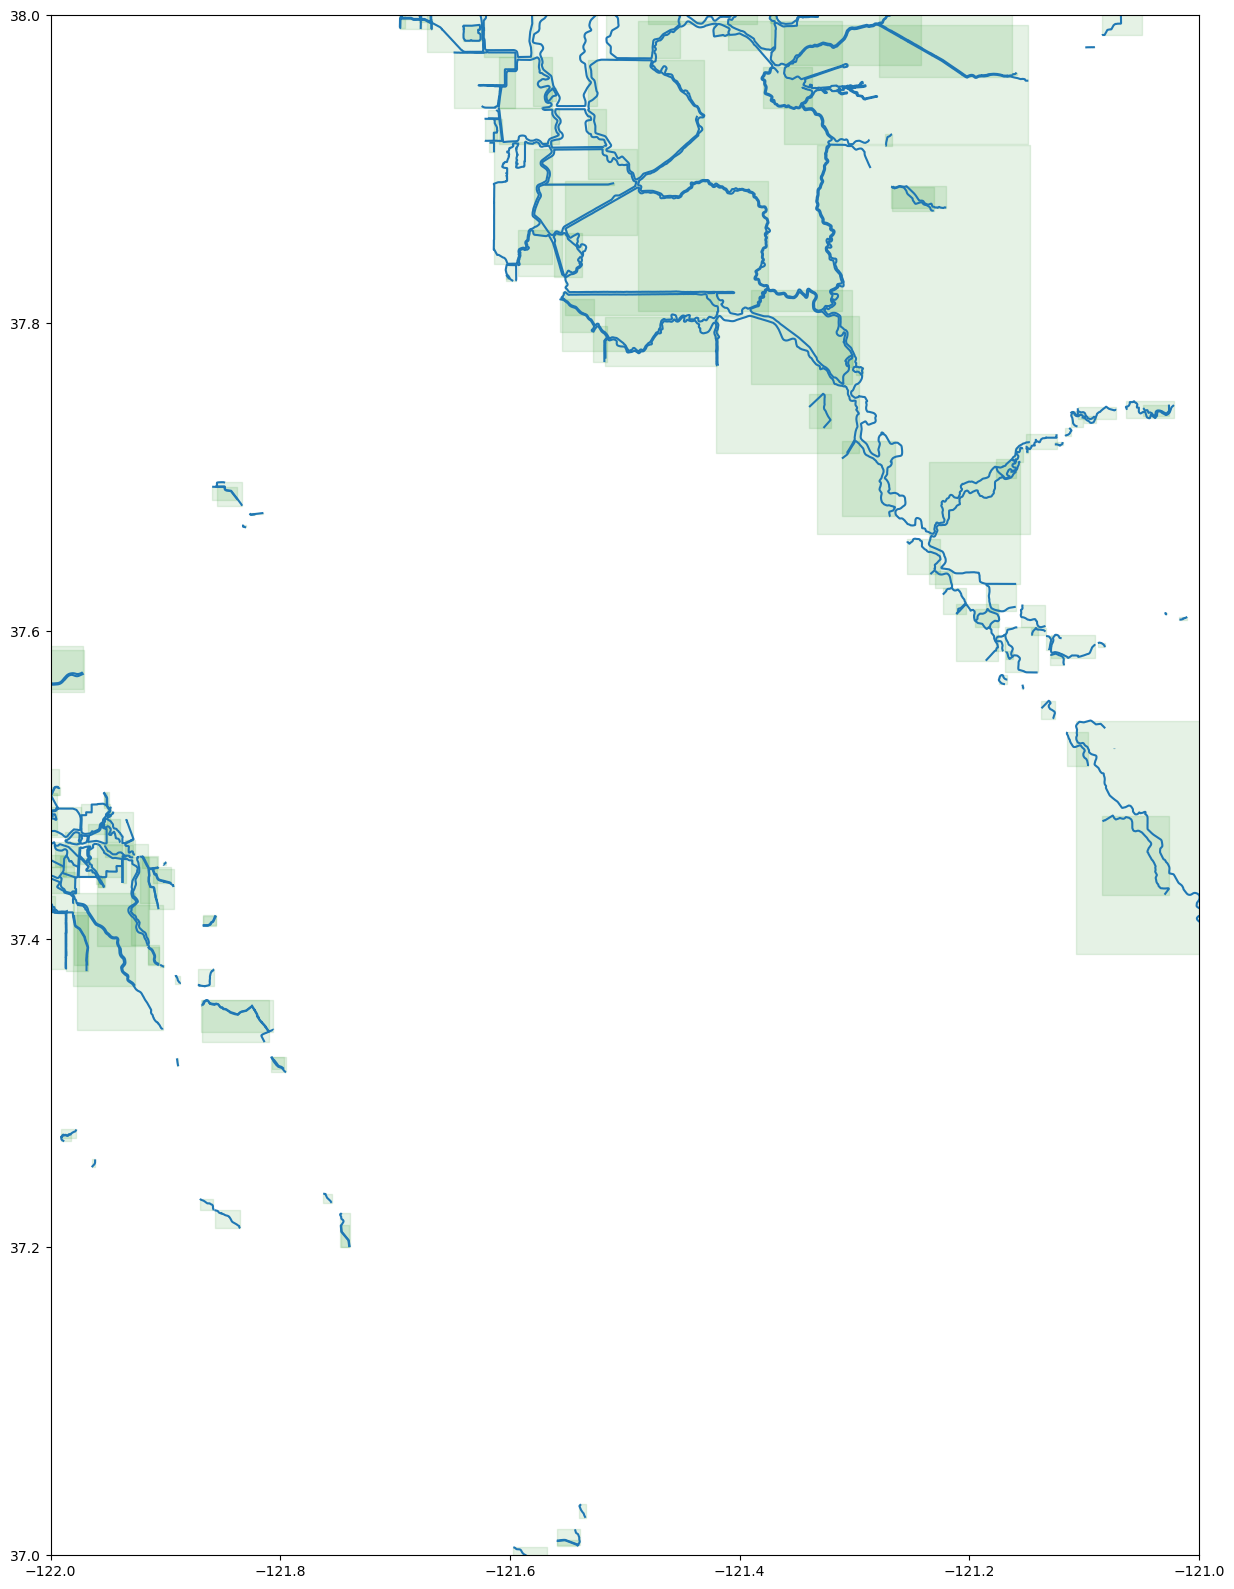

In [6]:
ax.set_xlim(-122,-121)
ax.set_ylim(37,38)
fig

We see that the bounding boxes can overlap with each other, causing the same region being queried multiple times.

# 3. Split the total bounds into cells

Another possible approach is to obtain the total bounds of all the levees, split the whole area into smaller cells, and check the intersect with levee data to remove empty cells. The remaining cells can be used to build the downloading requests.

In [7]:
# total bounds of the levee data
total_bounds = levee_gdf[["name", "geometry"]].geometry.total_bounds
print(total_bounds)

[-159.66659436   13.39761436  144.66929668   70.19657325]


Split the total bounds into cells with side length of 0.5 degrees:

In [8]:
from download_lidar_data import divide
cells = divide(total_bounds, 0.5)

Dividing the area into 609 x 114 squares


Build a mask to select cells where at least one levee intersect:

In [9]:
mask = cells.apply(lambda b: levee_gdf['geometry'].intersects(b).any())

Visualise the cells:

In [10]:
def build_patches_from_bbox(df_bounds, coord = ['minx','miny','maxx','maxy']):
    patches = []
    for index, bound in df_bounds.iterrows():
        patches.append(Rectangle(
            xy=(bound[coord[0]], bound[coord[1]]), 
            width=bound[coord[2]]-bound[coord[0]], 
            height=bound[coord[3]]-bound[coord[1]],
        ))
    return patches

Total number of cells 1141


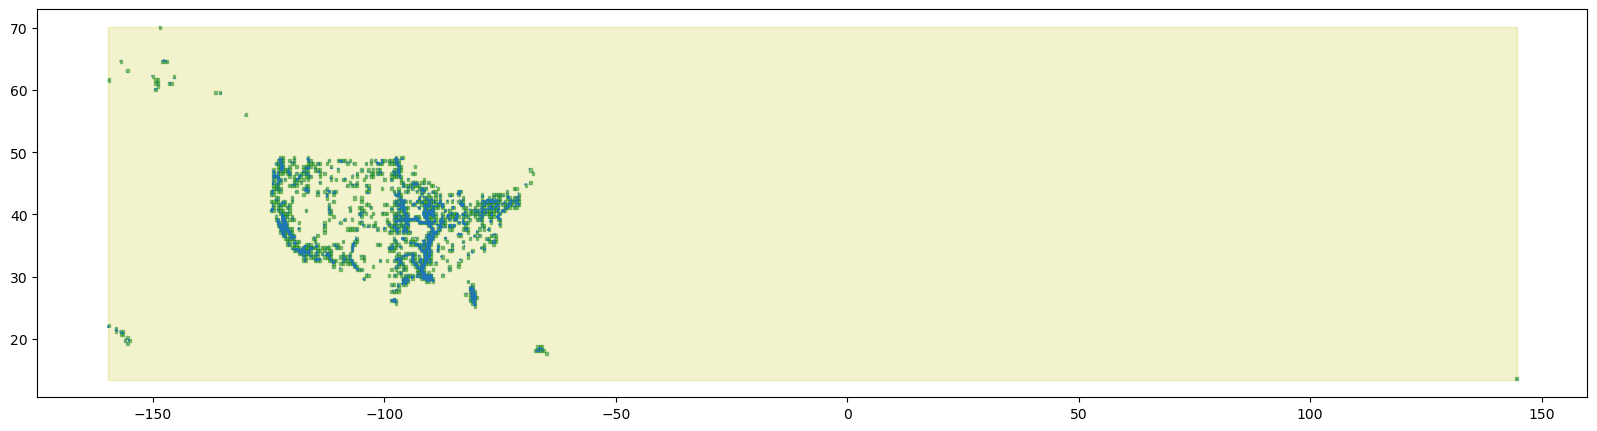

In [11]:
fig, ax = plt.subplots(figsize=(20, 20))
# plot levees
levee_gdf['geometry'].plot(ax=ax)

# plot the total_bounds in yellow
total_patch = Rectangle(
        xy=(total_bounds[0], total_bounds[1]), 
        width=total_bounds[2]-total_bounds[0], 
        height=total_bounds[3]-total_bounds[1],
    )
ax.add_collection(PatchCollection([total_patch], facecolor='y', edgecolor='y', alpha=0.2))

# plot the cells with levees
patches_grid = build_patches_from_bbox(cells[mask].bounds)
print("Total number of cells", len(cells[mask]))
ax.add_collection(PatchCollection(patches_grid, facecolor='g', edgecolor='g', alpha=0.4))

plt.show()

Zoom-in:

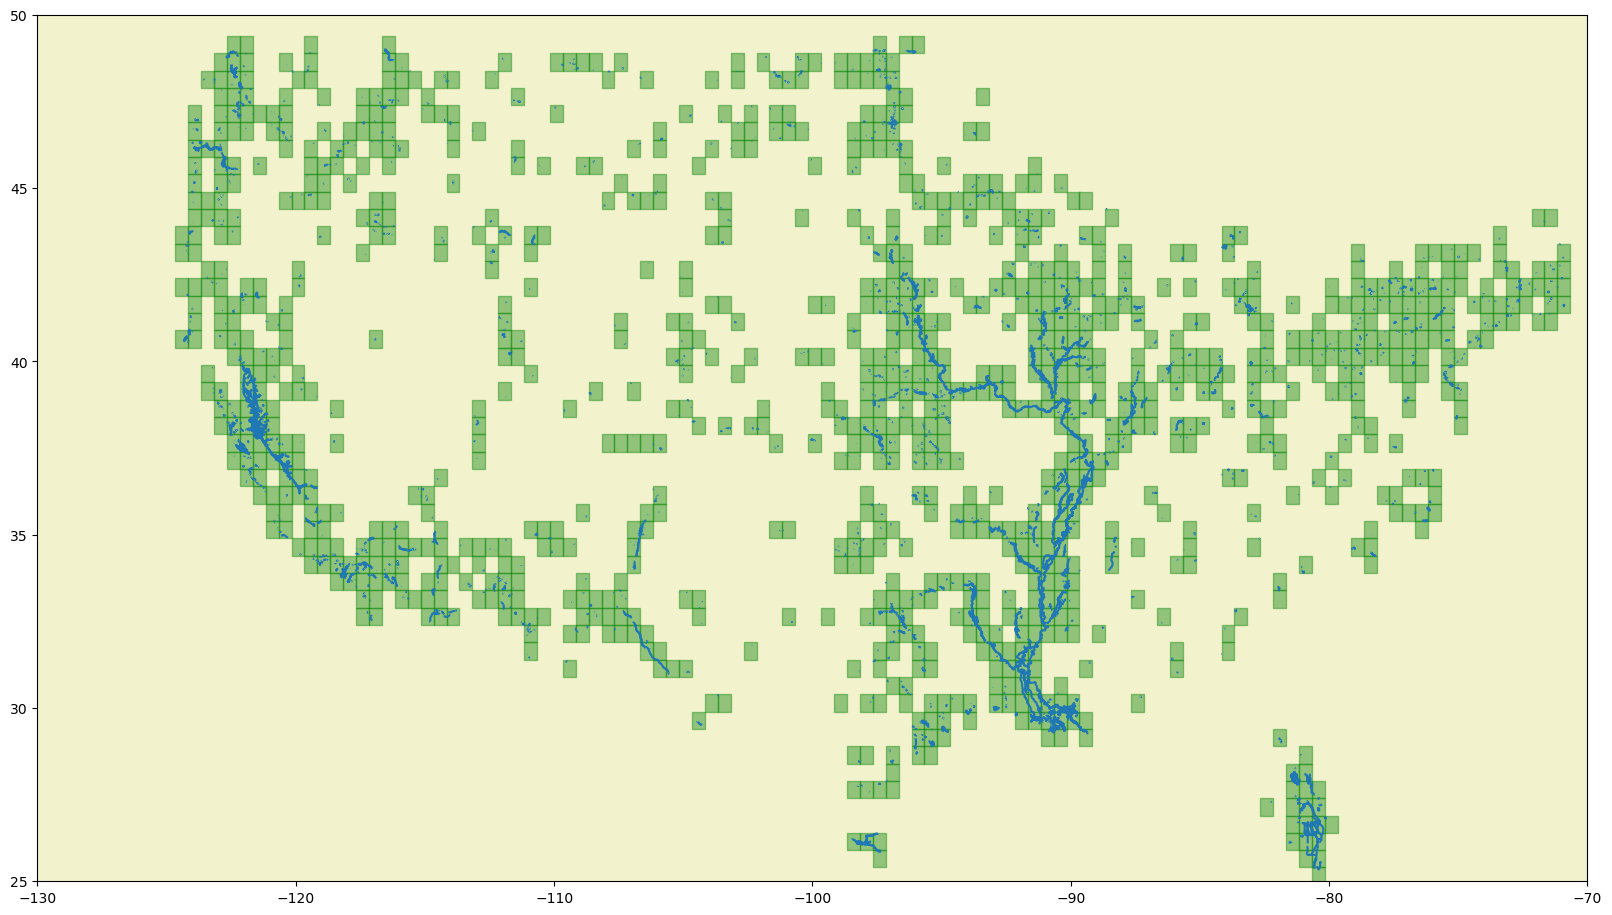

In [12]:
ax.set_xlim(-130, -70)
ax.set_ylim(25, 50)
fig

# 4. Build the request to the TNM Access API

Convert the selected cells to bounding boxes:

In [13]:
bbox_list = list(cells[mask].bounds.astype(str).stack().groupby(level=0).agg(",".join))
bbox_list

['144.33340564499971,13.397614362574174,144.83340564499971,13.897614362574174',
 '-65.16659435500029,17.397614362574174,-64.66659435500029,17.897614362574174',
 '-67.66659435500029,17.897614362574174,-67.16659435500029,18.397614362574174',
 '-67.16659435500029,17.897614362574174,-66.66659435500029,18.397614362574174',
 '-66.66659435500029,17.897614362574174,-66.16659435500029,18.397614362574174',
 '-66.16659435500029,17.897614362574174,-65.66659435500029,18.397614362574174',
 '-65.66659435500029,17.897614362574174,-65.16659435500029,18.397614362574174',
 '-67.16659435500029,18.397614362574174,-66.66659435500029,18.897614362574174',
 '-66.66659435500029,18.397614362574174,-66.16659435500029,18.897614362574174',
 '-66.16659435500029,18.397614362574174,-65.66659435500029,18.897614362574174',
 '-155.66659435500029,18.897614362574174,-155.16659435500029,19.397614362574174',
 '-156.16659435500029,19.397614362574174,-155.66659435500029,19.897614362574174',
 '-155.16659435500029,19.39761436257

Use the first bounding box in the list to make a request, and see the response of the API:

In [14]:
prodFormats = 'GeoTIFF'
bbox = bbox_list[0]
DATASETS = 'National Elevation Dataset (NED) 1/3 arc-second Current'
request_str = f"https://tnmaccess.nationalmap.gov/api/v1/products?&datasets={DATASETS}&prodFormats={prodFormats}"
if bbox:
    request_str = f"{request_str}&bbox={bbox}"
response = requests.get(request_str)
res = response.json()
print(res['messages'])

['Retrieved 1 item(s) Retrieved (1 through 50)']


In [15]:
print(res)

{'total': 1, 'items': [{'title': 'USGS 13 arc-second n14e144 1 x 1 degree', 'moreInfo': 'This tile of the 3D Elevation Program (3DEP) seamless products is 13 arc-second resolution. 3DEP data serve as the elevation layer of The National Map, and provide basic elevation information for Earth science studies and mapping applications in the United States. Scientists and resource managers use 3DEP data for global change research, hydrologic modeling, resource monitoring, mapping and visualization, and many other applications. 3DEP data compose an elevation dataset that consists of seamless layers and a high resolution layer. Each of these layers consists of the best available raster elevation data of the conterminous United States, Alaska, Hawaii, territorial islands, Mexico and Canada. 3DEP data are updated continually as [...]', 'sourceId': '5f77839982ce1d74e7d6c0fd', 'sourceName': 'ScienceBase', 'sourceOriginId': None, 'sourceOriginName': 'gda', 'metaUrl': 'https://www.sciencebase.gov/ca

The request returned 1 item. You can find the `sourceId` as a unique identifier of the item and also the `downloadURL` of this item.

In [16]:
print(res['items'][0]['sourceId'])
print(res['items'][0]['downloadURL'])

5f77839982ce1d74e7d6c0fd
https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/13/TIFF/historical/n14e144/USGS_13_n14e144_20130911.tif
